> __Purpose:__ This NB tests a finetuned centralized models and visualizes the train/test curves to investigate over/under-fitting

In [1]:
import pandas as pd
#import numpy as np
#import random
#np.random.seed(42) 

from moments_engr import *
from agglo_model_clust import *
from DNN_FT_funcs import *
from DNN_AMC_funcs import *
from hyperparam_tuned_configs import *


In [2]:
MODEL_STR = "DynamicMomonaNet"
MY_CONFIG = DynamicMomonaNet_config
NUM_LOCAL_MODELS = 15  # TODO: Double check that this is finetuning for just 15 users...
NUM_TRAINFT_GESTURES = 3

expdef_df = load_expdef_gestures(apply_hc_feateng=False)
all_participants = list(expdef_df['Participant'].unique())

full_path = os.path.join("C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\models\\hyperparam_tuning\\20250130_2003", 'originalHyperparamTuning_pretrained_DynamicMomonaNet_model.pth')
print("Full Path:", full_path)
# Load the pretrained model
pretrained_generic_model = select_model(MODEL_STR, MY_CONFIG)
pretrained_generic_model.load_state_dict(torch.load(full_path))


Full Path: C:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj\models\hyperparam_tuning\20250130_2003\originalHyperparamTuning_pretrained_DynamicMomonaNet_model.pth


<All keys matched successfully>

In [3]:
# Choosing NUM_LOCAL_MODELS somewhat arbitrarily, don't need to look at all 32 results... save some computation ig
# Setting num_gesture_training_trials=3 so that this replicates finetuning data used for local
# num_gesture_ft_trials should not be used I don't think, not in main_training_pipeline anyways
data_splits = make_data_split(expdef_df, num_gesture_training_trials=NUM_TRAINFT_GESTURES, num_gesture_ft_trials=NUM_TRAINFT_GESTURES, num_train_users=NUM_LOCAL_MODELS)


In [4]:
#def full_comparison_run(finetuning_datasplits)
finetuning_datasplits = data_splits

#local_user_dict = prepare_data_for_local_models(finetuning_datasplits, model_str, config)

#train_pids = np.unique(finetuning_datasplits['train']['participant_ids'])
novel_participant_ft_data = finetuning_datasplits['novel_trainFT']
novel_participant_test_data = finetuning_datasplits['cross_subject_test']
novel_pids = np.unique(finetuning_datasplits['novel_trainFT']['participant_ids'])

novel_pid_res_dict = {}
#res_dict_lst = []
res_dict = {}
for pid_count, pid in enumerate(novel_pids):
    print(f"PID {pid}, {pid_count}/{len(novel_pids)}")
    novel_pid_res_dict[pid] = {}

    # TODO: Confirm this is working as expected, it seems like this creates the subject specific dataloaders for me...
    ## If that is true then I didnt need to do all the Local development (for this func at least, on its own is another story)
    # Create the testloader by segmenting out this specific pid
    # Filter based on participant_id
    indices = [i for i, datasplit_pid in enumerate(novel_participant_ft_data['participant_ids']) if datasplit_pid == pid]
    ############## Novel Participant Finetuning Dataset ##############
    ft_dataset = GestureDataset([novel_participant_ft_data['feature'][i] for i in indices], [novel_participant_ft_data['labels'][i] for i in indices])
    ft_loader = DataLoader(ft_dataset, batch_size=MY_CONFIG["batch_size"], shuffle=True)
    ############## Novel Participant Intra Testing Dataset ##############
    indices = [i for i, datasplit_pid in enumerate(novel_participant_test_data['participant_ids']) if datasplit_pid == pid]
    # ^ These indices should be the same as the above indices I think...
    intra_test_dataset = GestureDataset([novel_participant_test_data['feature'][i] for i in indices], [novel_participant_test_data['labels'][i] for i in indices])
    intra_test_loader = DataLoader(intra_test_dataset, batch_size=MY_CONFIG["batch_size"], shuffle=True)
    ############## Novel Participant Cross Testing Dataset ##############
    # This code is testing on all the other novel participants... I don't think we care about that right now
    #indices = [i for i, datasplit_pid in enumerate(novel_participant_test_data['participant_ids']) if datasplit_pid != pid]
    #cross_test_dataset = GestureDataset([novel_participant_test_data['feature'][i] for i in indices], [novel_participant_test_data['labels'][i] for i in indices])
    #cross_test_loader = DataLoader(cross_test_dataset, batch_size=config["batch_size"], shuffle=True)

    # 3) Test finetuned pretrained model
    #def fine_tune_model(finetuned_model, fine_tune_loader, config, timestamp, test_loader=None, pid=None, use_earlystopping=None):
    # test_loss_log is for intra_test!
    ft_centralized_model, original_petrained_model, train_loss_log, test_loss_log = fine_tune_model(
        pretrained_generic_model, ft_loader, MY_CONFIG, MY_CONFIG['timestamp'], test_loader=intra_test_loader, pid=pid)
    res_dict[pid] = (train_loss_log, test_loss_log)
    #ft_centralized_res = evaluate_model(ft_centralized_model, intra_test_loader)
    #novel_pid_res_dict[pid]["ft_centralized_acc"] = ft_centralized_res["accuracy"]
    

PID P005, 0/17


c:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj\gesture_dataset_classes.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  self.features = torch.tensor(features, dtype=torch.float32)


PID P008, 1/17
PID P010, 2/17
PID P011, 3/17
PID P102, 4/17
PID P103, 5/17
PID P104, 6/17
PID P105, 7/17
PID P107, 8/17
PID P108, 9/17
PID P109, 10/17
PID P116, 11/17
PID P118, 12/17
PID P121, 13/17
PID P124, 14/17
PID P127, 15/17
PID P131, 16/17


In [5]:
#return {
#    'model': model,
#    'train_performance': train_performance,
#    'intra_test_performance': intra_test_performance,
#    'cross_test_performance': cross_test_performance,
#    # These are the final accuracies on the respective datasets
#    'train_accuracy': train_results['accuracy'],
#    'intra_test_accuracy': intra_test_results['accuracy'],
#    'cross_test_accuracy': cross_test_results['accuracy'], 
#    'train_loss_log': train_loss_log,
#    'intra_test_loss_log': intra_test_loss_log,
#    'cross_test_loss_log': cross_test_loss_log
#}

In [7]:
res_keys = list(res_dict.keys())
print(res_keys)

['P005', 'P008', 'P010', 'P011', 'P102', 'P103', 'P104', 'P105', 'P107', 'P108', 'P109', 'P116', 'P118', 'P121', 'P124', 'P127', 'P131']


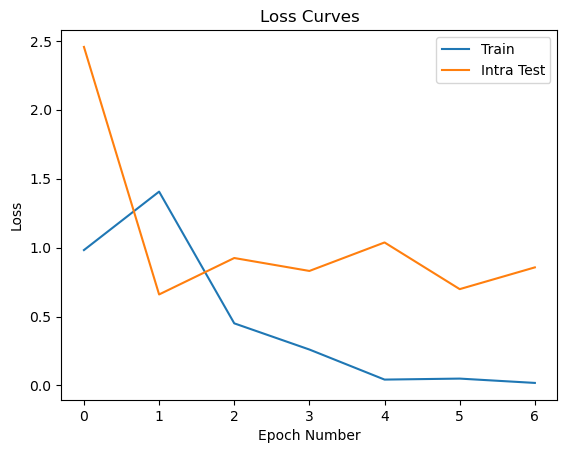

In [9]:
user_res_lst = res_dict[res_keys[0]]

plt.plot(user_res_lst[0], label="Train")
plt.plot(user_res_lst[1], label="Intra Test")
plt.title("Loss Curves")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.show()


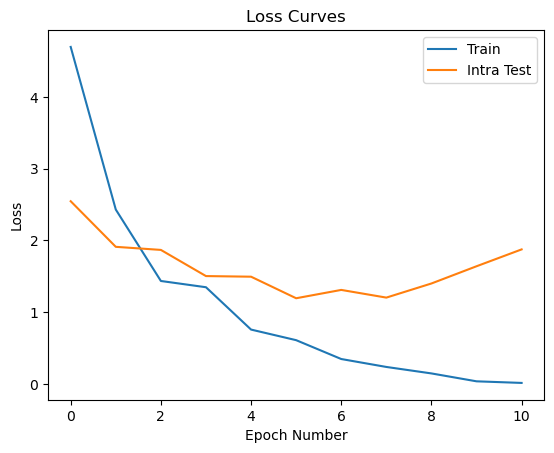

In [10]:
user_res_lst = res_dict[res_keys[1]]

plt.plot(user_res_lst[0], label="Train")
plt.plot(user_res_lst[1], label="Intra Test")
plt.title("Loss Curves")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.show()

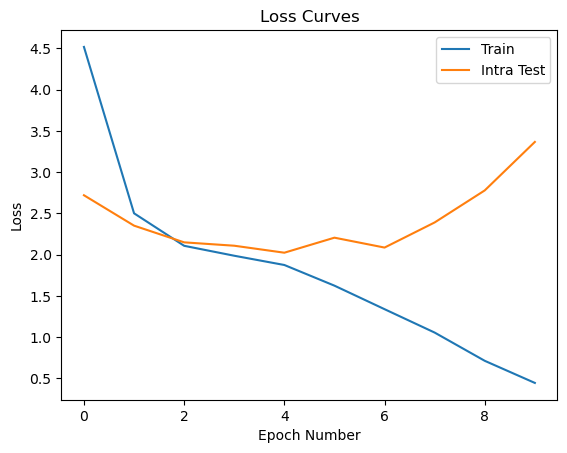

In [11]:
user_res_lst = res_dict[res_keys[2]]

plt.plot(user_res_lst[0], label="Train")
plt.plot(user_res_lst[1], label="Intra Test")
plt.title("Loss Curves")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Rerun With No Early Stopping

In [12]:
MY_CONFIG = copy.deepcopy(DynamicMomonaNet_config)
# Turning off early stopping!
MY_CONFIG['num_epochs'] = 50
MY_CONFIG['use_earlystopping'] = False


In [13]:
#def full_comparison_run(finetuning_datasplits)
finetuning_datasplits = data_splits

#local_user_dict = prepare_data_for_local_models(finetuning_datasplits, model_str, config)

#train_pids = np.unique(finetuning_datasplits['train']['participant_ids'])
novel_participant_ft_data = finetuning_datasplits['novel_trainFT']
novel_participant_test_data = finetuning_datasplits['cross_subject_test']
novel_pids = np.unique(finetuning_datasplits['novel_trainFT']['participant_ids'])

novel_pid_res_dict = {}
#res_dict_lst = []
res_dict = {}
for pid_count, pid in enumerate(novel_pids):
    print(f"PID {pid}, {pid_count}/{len(novel_pids)}")
    novel_pid_res_dict[pid] = {}

    # TODO: Confirm this is working as expected, it seems like this creates the subject specific dataloaders for me...
    ## If that is true then I didnt need to do all the Local development (for this func at least, on its own is another story)
    # Create the testloader by segmenting out this specific pid
    # Filter based on participant_id
    indices = [i for i, datasplit_pid in enumerate(novel_participant_ft_data['participant_ids']) if datasplit_pid == pid]
    ############## Novel Participant Finetuning Dataset ##############
    ft_dataset = GestureDataset([novel_participant_ft_data['feature'][i] for i in indices], [novel_participant_ft_data['labels'][i] for i in indices])
    ft_loader = DataLoader(ft_dataset, batch_size=MY_CONFIG["batch_size"], shuffle=True)
    ############## Novel Participant Intra Testing Dataset ##############
    indices = [i for i, datasplit_pid in enumerate(novel_participant_test_data['participant_ids']) if datasplit_pid == pid]
    # ^ These indices should be the same as the above indices I think...
    intra_test_dataset = GestureDataset([novel_participant_test_data['feature'][i] for i in indices], [novel_participant_test_data['labels'][i] for i in indices])
    intra_test_loader = DataLoader(intra_test_dataset, batch_size=MY_CONFIG["batch_size"], shuffle=True)
    ############## Novel Participant Cross Testing Dataset ##############
    # This code is testing on all the other novel participants... I don't think we care about that right now
    #indices = [i for i, datasplit_pid in enumerate(novel_participant_test_data['participant_ids']) if datasplit_pid != pid]
    #cross_test_dataset = GestureDataset([novel_participant_test_data['feature'][i] for i in indices], [novel_participant_test_data['labels'][i] for i in indices])
    #cross_test_loader = DataLoader(cross_test_dataset, batch_size=config["batch_size"], shuffle=True)

    # 3) Test finetuned pretrained model
    #def fine_tune_model(finetuned_model, fine_tune_loader, config, timestamp, test_loader=None, pid=None, use_earlystopping=None):
    # test_loss_log is for intra_test!
    ft_centralized_model, original_petrained_model, train_loss_log, test_loss_log = fine_tune_model(
        pretrained_generic_model, ft_loader, MY_CONFIG, MY_CONFIG['timestamp'], test_loader=intra_test_loader, pid=pid)
    res_dict[pid] = (train_loss_log, test_loss_log)
    #ft_centralized_res = evaluate_model(ft_centralized_model, intra_test_loader)
    #novel_pid_res_dict[pid]["ft_centralized_acc"] = ft_centralized_res["accuracy"]
    

PID P005, 0/17
PID P008, 1/17
PID P010, 2/17
PID P011, 3/17
PID P102, 4/17
PID P103, 5/17
PID P104, 6/17
PID P105, 7/17
PID P107, 8/17
PID P108, 9/17
PID P109, 10/17
PID P116, 11/17
PID P118, 12/17
PID P121, 13/17
PID P124, 14/17
PID P127, 15/17
PID P131, 16/17


In [14]:
res_keys = list(res_dict.keys())
print(res_keys)

['P005', 'P008', 'P010', 'P011', 'P102', 'P103', 'P104', 'P105', 'P107', 'P108', 'P109', 'P116', 'P118', 'P121', 'P124', 'P127', 'P131']


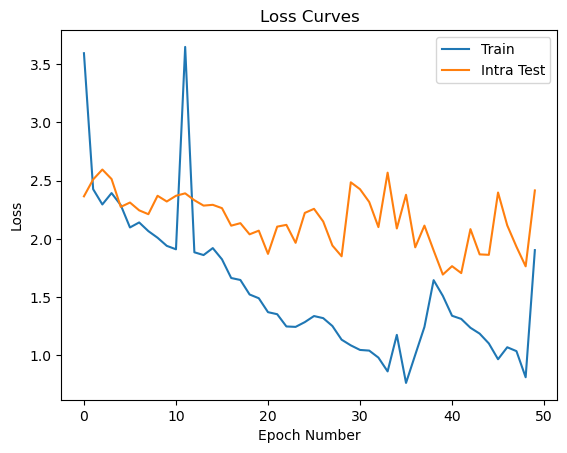

In [15]:
user_res_lst = res_dict[res_keys[0]]

plt.plot(user_res_lst[0], label="Train")
plt.plot(user_res_lst[1], label="Intra Test")
plt.title("Loss Curves")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.show()


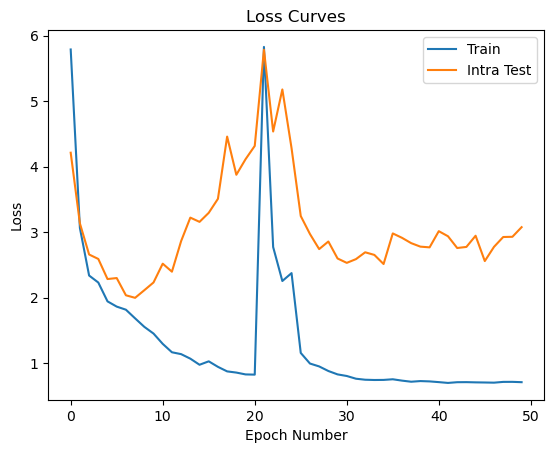

In [16]:
user_res_lst = res_dict[res_keys[1]]

plt.plot(user_res_lst[0], label="Train")
plt.plot(user_res_lst[1], label="Intra Test")
plt.title("Loss Curves")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.show()

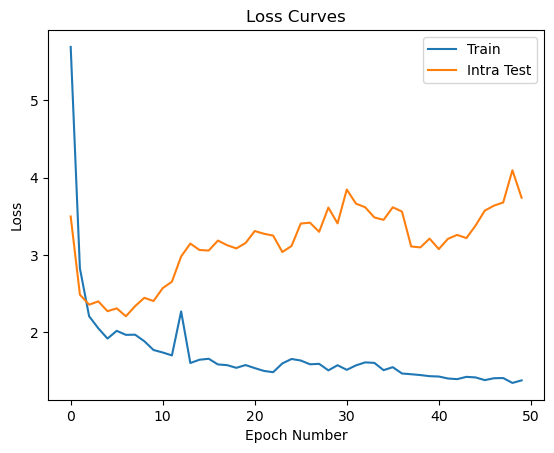

In [17]:
user_res_lst = res_dict[res_keys[2]]

plt.plot(user_res_lst[0], label="Train")
plt.plot(user_res_lst[1], label="Intra Test")
plt.title("Loss Curves")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.show()